In [2]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.20.0
Num GPUs Available: 0


In [4]:
# Then import the required libraries
import importlib
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
# Remove standalone keras imports and use tf.keras instead
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Update keras imports to use tf.keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
# Use tf.keras.models instead
from sklearn.model_selection import GridSearchCV
import joblib

In [5]:
seed = 0
np.random.seed(seed)

df = pd.read_csv('gene_level_methylation.csv')

print("Original columns:", df.columns.tolist()[:10], "...")

# Remove the "SingleValueType" column if it exists
if "SingleValueType" in df.columns:
    df = df.drop(columns=["SingleValueType"])
    print("Column 'SingleValueType' has been removed successfully.")
else:
    print("Column 'SingleValueType' does not exist in the DataFrame.")

# Sort columns and transpose
df = df.reindex(sorted(df.columns), axis=1)
df = df.T

# Set first row (originally "GeneSymbol") as new column names
df.columns = df.iloc[0]  # first row becomes column headers
df = df.drop(df.index[0])  # drop the first row

print("CNV Matrix After Transpose and Header Fix:", df.shape)
print("\nDataFrame preview:")
df.head()

Original columns: ['GeneSymbol', 'SingleValueType', 'TCGA-OL-A66H-01', 'TCGA-3C-AALK-01', 'TCGA-AC-A5EH-01', 'TCGA-EW-A2FW-01', 'TCGA-E9-A1R0-01', 'TCGA-AR-A1AJ-01', 'TCGA-AC-A62Y-01', 'TCGA-E9-A1QZ-01'] ...
Column 'SingleValueType' has been removed successfully.
CNV Matrix After Transpose and Header Fix: (888, 19277)

DataFrame preview:


GeneSymbol,RPS4Y2,RPS4Y1,TBL1Y,NLGN4Y,PRKY,PCDH11Y,TTTY20,GABRE,FTHL17,PORCN,...,EP300,DERL3,PLA2G3,TMPRSS6,MIR1281,GGT3P,UBE2L3,APOL5,SLC5A1,CDC42EP1
TCGA-3C-AAAU-01,0.527,0.57214,0.447925,0.052075,0.1233,0.0581,0.50125,0.377325,0.878033,0.365011,...,0.099,0.04835,0.7942,0.86505,0.099,0.8638,0.3368,0.928,0.1865,0.0178
TCGA-3C-AALI-01,0.6489,0.5074,0.426008,0.07245,0.8148,0.0836,0.473473,0.387325,0.758033,0.254889,...,0.0617,0.38345,0.7698,0.8228,0.0617,0.8317,0.8098,0.8742,0.8993,0.0234
TCGA-3C-AALJ-01,0.6949,0.563733,0.464233,0.0675,0.7933,0.0627,0.45565,0.333725,0.6283,0.473433,...,0.075,0.4813,0.7681,0.8433,0.075,0.7911,0.44875,0.8888,0.739,0.031
TCGA-3C-AALK-01,0.5778,0.5722,0.50945,0.34105,0.6853,0.2694,0.5769,0.53885,0.9241,0.417256,...,0.0856,0.5369,0.7532,0.83555,0.0856,0.8151,0.3113,0.9321,0.763,0.0274
TCGA-4H-AAAK-01,0.4716,0.5077,0.45365,0.063675,0.6571,0.3482,0.438033,0.480625,0.9169,0.469724,...,0.0808,0.1768,0.6704,0.7699,0.0808,0.8049,0.2855,0.937,0.7207,0.0268


In [6]:
df2=pd.read_csv('BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '-') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]
df2.head()

Clinical Data Before: (1247, 202)


,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,Integrated_Clusters_no_exp__nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
TCGA-A1-A0SB-01,Stage I,70.0,1.0,Stage I,259.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SB-01A-11D-A142-09,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,NaN,TCGA-A1-A0SB-01A-11D-A141-01,TCGA-A1-A0SB-01,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,TCGA-A1-A0SB-01A-11D-A141-01,NaN
TCGA-A1-A0SD-01,Stage IIA,59.0,2.0,Stage IIA,437.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SD-01A-11D-A10Y-09,NaN,15bad71d-3031-413b-9e8d-6426ae5dfbea,NaN,TCGA-A1-A0SD-01A-11D-A111-01,TCGA-A1-A0SD-01,TCGA-A1-A0SD-01A-11R-A115-07,15bad71d-3031-413b-9e8d-6426ae5dfbea,TCGA-A1-A0SD-01A-11D-A111-01,TCGA-A1-A0SD-01
TCGA-A1-A0SE-01,Stage I,56.0,2.0,Stage I,1320.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SE-01A-11D-A099-09,TCGA-A1-A0SE-01,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01,TCGA-A1-A0SE-01A-11D-A087-01,NaN,TCGA-A1-A0SE-01A-11R-A084-07,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01A-11D-A087-01,TCGA-A1-A0SE-01
TCGA-A1-A0SF-01,Stage IIA,54.0,3.0,Stage IIA,1463.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SF-01A-11D-A142-09,NaN,28089e15-5e2c-4e83-ba6c-62b3cb40e431,NaN,TCGA-A1-A0SF-01A-11D-A141-01,TCGA-A1-A0SF-01,NaN,28089e15-5e2c-4e83-ba6c-62b3cb40e431,TCGA-A1-A0SF-01A-11D-A141-01,NaN
TCGA-A1-A0SG-01,Stage IIB,61.0,4.0,Stage IIB,433.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SG-01A-11D-A142-09,NaN,0df6b948-367d-4951-9d98-d3bebabff63e,NaN,TCGA-A1-A0SG-01A-11D-A141-01,TCGA-A1-A0SG-01,NaN,0df6b948-367d-4951-9d98-d3bebabff63e,TCGA-A1-A0SG-01A-11D-A141-01,NaN


In [7]:
commonIndexes=np.sort(list(set(df2.index).intersection(set(df.index)))) 
df=df.loc[commonIndexes] 
df2=df2.loc[commonIndexes] 
print("Data After:", df.shape) 
print("Clinical Data After:", df2.shape) 
print("CNV and Clinical Data corresponds to same Patients: ", False if False in (df.index==df2.index) else True) 
unique_elements, counts_elements = np.unique(df2.iloc[:,k], return_counts=True) 
print("Labels", unique_elements, counts_elements)

Data After: (620, 19277)
Clinical Data After: (620, 202)
CNV and Clinical Data corresponds to same Patients:  True
Labels ['Basal' 'Her2' 'LumA' 'LumB' 'Normal'] [ 87  31 288 127  87]


In [8]:
#all genes

In [9]:
original_feature_names = df.columns.tolist()
X=np.array(df.values, dtype=float)
X.shape
Y=np.array(df2.values[:,k])
Y.shape

(620,)

In [10]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [11]:
folds = list(skf.split(X, Y))

# Select fold 4
train_idx, test_idx = folds[4]
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

X_train.shape, X_test.shape

((496, 19277), (124, 19277))

In [12]:
# Define features (X) and labels (y)
X = df.values.astype(float)    # features must be numeric
y = df2.iloc[:, k].values      # PAM50 labels
original_feature_names = df.columns.tolist()

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", np.unique(y))

Feature matrix shape: (620, 19277)
Labels shape: (620,)
Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# -------------------------------
# CONFIGURATION
# -------------------------------
seed = 0
np.random.seed(seed)

# Load data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
n_classes = len(le.classes_)


# One-hot encode labels
y_train_oh = to_categorical(y_train_enc, num_classes=n_classes)
y_test_oh = to_categorical(y_test_enc, num_classes=n_classes)

input_dim = X_train.shape[1]

# -------------------------------
# AUTOENCODER (fixed)
# -------------------------------
def build_autoencoder(input_dim, encoding_dim=500, hidden_dim1=5000, hidden_dim2=2000, 
                      l2_reg=1e-14, learning_rate=3e-5):
    """Build encoder + autoencoder"""
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = ReLU()(x)
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    encoded = Dense(encoding_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded = ReLU()(encoded)
    
    # Decoder
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(encoded)
    x = ReLU()(x)
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    decoded = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=inp, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    encoder = Model(inputs=inp, outputs=encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, verbose=1, shuffle=True)

# Encode features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)



Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0000e+00 - loss: 0.1369
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0101 - loss: 0.0183   
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3044 - loss: 0.0090
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0060 - loss: 0.0079
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.0040 - loss: 0.0076
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3569 - loss: 0.0076
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.2117 - loss: 0.0076
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1512 - loss: 0.0076
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2056 - loss: 0.0075
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2238 - loss: 0.0075
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2298 - loss: 0.0074
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - ac

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


def create_classifier(hidden_dim=200, dropout_rate1=0.2, dropout_rate2=0.3, 
                      learning_rate=2e-5, activation='relu', regularization=None):
    inp = Input(shape=(X_train_encoded.shape[1],))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rate1, seed=seed)(x)

    # Choose regularization
    if regularization == 'l1':
        reg = regularizers.l1(1e-14)
    elif regularization == 'l2':
        reg = regularizers.l2(1e-14)
    elif regularization == 'l1_l2':
        reg = regularizers.l1_l2(1e-14, 1e-14)
    else:
        reg = None

    # Activation
    if activation == 'leakyrelu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = LeakyReLU(negative_slope=0.01)(x)
    elif activation == 'relu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = ReLU()(x)
    else:
        x = Dense(hidden_dim, activation='tanh', kernel_regularizer=reg)(x)

    x = BatchNormalization()(x)
    x = Dropout(dropout_rate2, seed=seed)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier
clf = KerasClassifier(
    model=create_classifier,
    epochs=100,
    verbose=0,
    random_state=seed,
)

# -------------------------------
# RANDOMIZED SEARCH
# -------------------------------
param_dist = {
    'model__hidden_dim': [200],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'model__dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__learning_rate': [0.01, 0.002, 0.001, 0.0001],
    'model__activation': ['relu', 'tanh', 'leakyrelu'],
    'model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64],
}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=2,
    random_state=seed,
    verbose=2
)

start = time.time()
random_search.fit(X_train_encoded, y_train)
end = time.time()
print(f"RandomizedSearchCV completed in {(end-start)/60:.2f} minutes")

# -------------------------------
# EVALUATION
# -------------------------------
best_model = random_search.best_estimator_

y_pred_classes = best_model.predict(X_test_encoded)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomizedSearchCV Best Model')
plt.tight_layout()
plt.show()

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=  12.1s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=  10.8s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=  10.1s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=  15.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   7.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   7.3s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=  10.5s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=  11.1s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   9.8s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   9.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   8.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   9.1s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   8.5s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   7.7s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   7.9s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   8.5s
[CV

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=  12.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=  11.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   8.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=  11.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=  12.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=  11.9s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=  12.5s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=  12.9s
[CV] END batch_size=

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=None; total time=   9.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=None; total time=   9.4s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   9.1s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   8.6s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=  10.4s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=  11.1s
[CV] END

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=  13.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


KeyboardInterrupt: 


Classification Accuracy: 0.7339

Classification Report (Fixed Classifier):
              precision    recall  f1-score   support

       Basal       0.88      0.88      0.88        17
        Her2       0.75      0.43      0.55         7
        LumA       0.74      0.74      0.74        58
        LumB       0.56      0.60      0.58        25
      Normal       0.83      0.88      0.86        17

    accuracy                           0.73       124
   macro avg       0.75      0.71      0.72       124
weighted avg       0.74      0.73      0.73       124



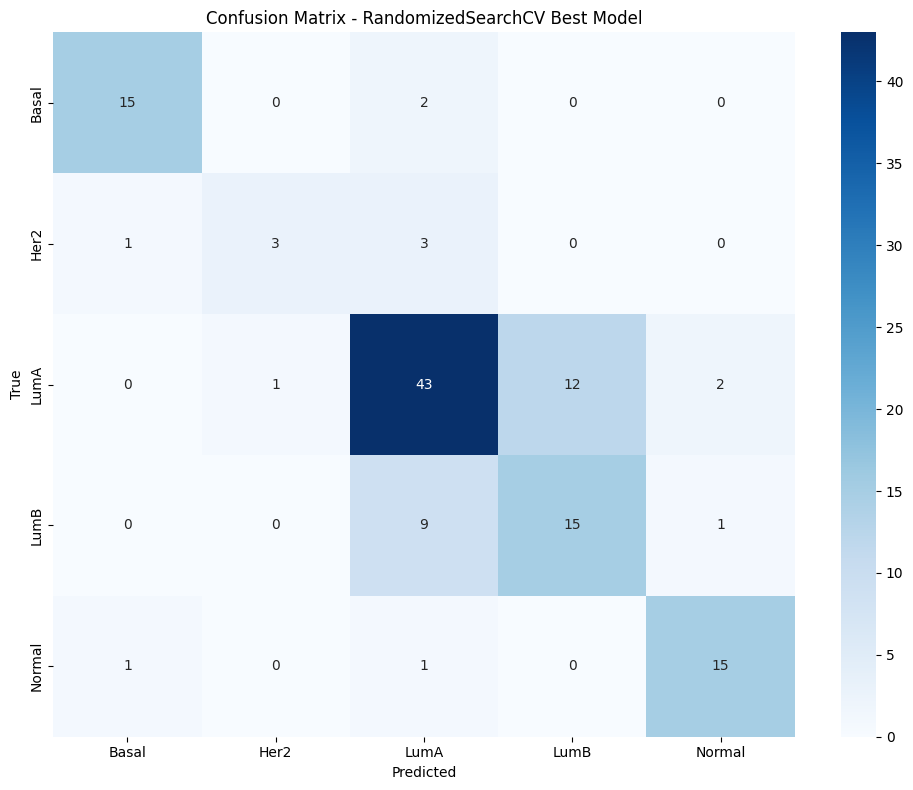

In [8]:
from sklearn.metrics import accuracy_score
y_pred_probs = best_model.predict(X_test_encoded)



accuracy = accuracy_score(y_test_enc, y_pred_classes)
print(f"\nClassification Accuracy: {accuracy:.4f}")

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nClassification Report (Fixed Classifier):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomizedSearchCV Best Model')
plt.tight_layout()
plt.show()

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4268 - loss: 1.7360 - val_accuracy: 0.5000 - val_loss: 1.5518
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6944 - loss: 0.9459 - val_accuracy: 0.5000 - val_loss: 1.4971
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6970 - loss: 0.9651 - val_accuracy: 0.5100 - val_loss: 1.5707
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7475 - loss: 0.8443 - val_accuracy: 0.5100 - val_loss: 1.4490
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7475 - loss: 0.7871 - val_accuracy: 0.5600 - val_loss: 1.2504
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7626 - loss: 0.8250 - val_accuracy: 0.6600 - val_loss: 0.9546
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7500 - loss: 0.7324 - val_accuracy: 0.6900 - val_loss: 0.9317
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7273 - loss: 0.7134 - val_accuracy: 0.730

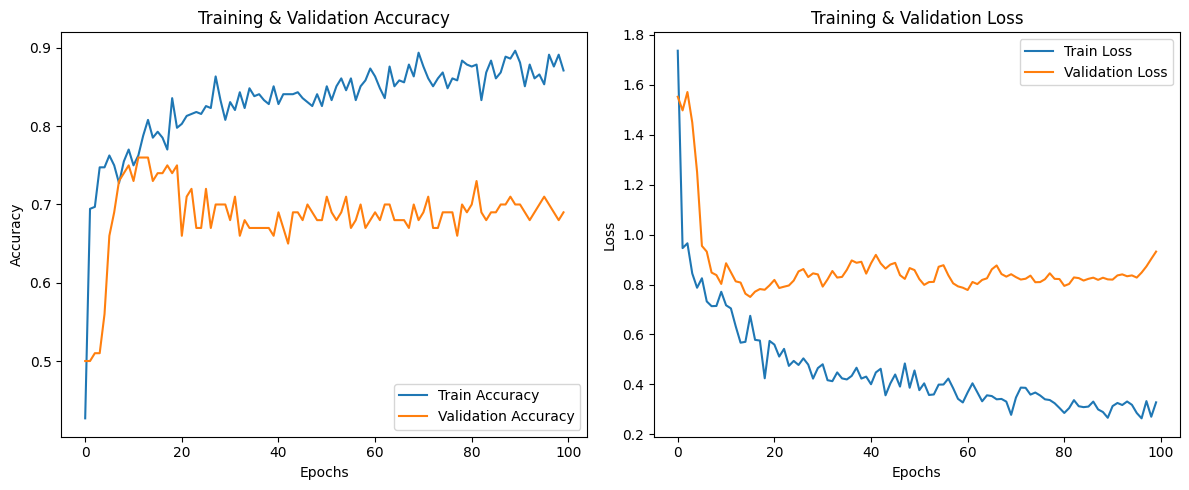

In [3]:
# -------------------------------
# RETRAIN BEST MODEL WITH VALIDATION
# -------------------------------
# Get best parameters from RandomizedSearchCV
best_params = random_search.best_params_

# Rebuild the model using best_params
retrained_model = create_classifier(
    hidden_dim=best_params['model__hidden_dim'],
    dropout_rate1=best_params['model__dropout_rate1'],
    dropout_rate2=best_params['model__dropout_rate2'],
    learning_rate=best_params['model__learning_rate'],
    activation=best_params['model__activation'],
    regularization=best_params['model__regularization']
)

# Compile with categorical_crossentropy because we have one-hot labels
retrained_model.compile(
    optimizer=Adam(learning_rate=best_params['model__learning_rate']),
    loss='categorical_crossentropy',  # <-- changed
    metrics=['accuracy']
)

# Fit with validation_split to get val_loss/val_accuracy
history = retrained_model.fit(
    X_train_encoded,
    y_train_oh,               # one-hot labels
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['batch_size'],
    verbose=1
)

# -------------------------------
# PREDICT AND EVALUATE
# -------------------------------
y_pred_probs = retrained_model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # convert probs to class indices

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# -------------------------------
# PLOT TRAINING HISTORY
# -------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
rf = best_model.named_steps['rf']

if len(original_feature_names) != len(rf.feature_importances_):
    print(f"Warning: Number of feature names ({len(original_feature_names)}) doesn't match number of features used ({len(rf.feature_importances_)})")
    # Use generic names if there's a mismatch
    feature_names = [f'Feature {i}' for i in range(len(rf.feature_importances_))]
else:
    feature_names = original_feature_names

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 20 features
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance.head(top_n), x='Importance', y='Feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

print("Top 20 features by importance:")
print(feature_importance['Feature'].head(20).tolist())

AttributeError: 'Sequential' object has no attribute 'named_steps'